# Functional Approach to Querying the IMDb Database
## Name: John Park

The Internet Movie Database (IMDb) is an online database of information related to films, television programs, home videos, and video games. Users can access details about movies, TV shows, actors, directors, production crew, and more on IMDb. It's widely used by industry professionals, film enthusiasts, and general audiences for research, reviews, ratings, and recommendations.

A subset of the IMDb data was used to create an SQLite database file `imdb.db` that contains data the available data through 3/27/2022.  In this notebook we define a Python function `show_rating(dbcon, show_title)` that will perform SQL queries to the IMDb database (with the connection `dbcon`) to determine some interesting facts about the provided title of the show (`show_title`). Specifically, the function only examines shows with at least multiple episodes (as opposed to movies, etc) and ratings. The function displays the following information:

- The number of seasons.

- The overall rating of each season (season number, year premiered, and average rating).

- The highest and lowest episode (season number, episode number, episode title, and rating)

- A line graph of the episodes' ratings, represented on multiple lines for each season.

Another Python function `director_actor(dbcon, director_name)` is defined and will perform SQL queries to the IMDb database (with the connection `dbcon`) to determine some interesting facts about the provided director's name (`director_name`). Specifically, the function only examines actors who were casted in the director's movies (as opposed to TV shows, etc) and displays the following information:

- The number of casted actors.

- A histogram that represnts the appearance of actors.

- The most appeared actor (movie titles, premiered year, actor's age, and rating)
  
    - A line graph of the movies' ratings.

## Import the needed libraries

We begin by importing the libraries that we will need.

In [1]:
import sqlalchemy as sa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Connect to the IMDb database

Now we connect to the sqlite IMDb database which is assumed to be in the **same directory as this notebook.**

In [2]:
cstring = 'sqlite+pysqlite:///imdb.db'
engine = sa.create_engine(cstring)
connection = engine.connect()

## Function Definition: show_rating()

In the code cell below we define the`show_rating(dbcon, show_title)` function.  This function is designed to analyze and provide insights on show's ratings based on data strored in the `imdb.db` database. Here's a breakdown of what it does:

**SQL Query Construction:** The function constructs two SQL queries using a text-based approach with *binding*. These queries are used to extract specific information from the database related to the show's overall rating of each seasons and a range of ratings.
 
**Executing SQL Queries:** After constructing the SQL queries, the function *binds* the necessary parameters (like the show's title) and executes the queries using Pandas' `read_sql_query()` function to read the SQL results into a DataFrame.

**Textual Output:** The function then prints out textual information about a summary of the show's ratings, including its season counts, average rating of each seasons, lowest/highest rated episodes, premiered year, and the titles. It also highlights the season with unrecorded ratings.

**Data Visualization:** The function also generates a graph showing the episodes' ratings of each season on multiple lines. It utilizes the second query to create and display the line graph.

In [3]:
def show_rating(dbcon, show_title):
    
    # Define the SQL query needed for the text output of grouped seasons using the binding method
    pyquery1 = """
    SELECT season_number, n.premiered, ROUND(AVG(rating), 2) AS season_rating
    FROM episodes AS e
    INNER JOIN titles AS t ON e.show_title_id = t.title_id
    LEFT JOIN ratings AS r ON r.title_id = e.episode_title_id
    INNER JOIN (SELECT title_id, premiered FROM titles) AS n ON e.episode_title_id = n.title_id
    WHERE t.primary_title = :title_in
    GROUP BY e.season_number;
    """
    
    # Bind the query
    prepare_stmt = sa.sql.text(pyquery1)
    bound_stmt = prepare_stmt.bindparams(title_in = show_title)
    
    # Pass the query to the DBMS and obtain the resulting table as a dataframe
    df1 = pd.read_sql_query(bound_stmt, dbcon)

    # Print the show title
    print("===========================================")
    print("Show: " + show_title)
    print("===========================================")
    print()
    
    # Print number of seasons
    print("Number of seasons: " + str(len(df1.season_number)))
    print()
    
    # Print the year premiered and rating for each season
    for index, season in df1.iterrows():
        # Inform which season doesn't have ratings
        if np.isnan(season['season_rating']):
            print("Season "+str(int(season['season_number']))+" doesn't have recorded ratings!")
        else:
            print("Season "+str(int(season['season_number']))+" was premiered in "+str(int(season['premiered'])))
            print("The average rating is "+str(season['season_rating']))
        print()
    print("===========================================")
    print()

    #Define the SQL query needed for the text output and line graph using the binding method
    pyquery2 = """
    SELECT e.season_number, e.eposide_number AS episode_number, n.episode_title, n.premiered, r.rating
    FROM episodes AS e
    INNER JOIN titles AS t ON e.show_title_id = t.title_id
    INNER JOIN ratings AS r ON r.title_id = e.episode_title_id
    INNER JOIN (SELECT primary_title AS episode_title, premiered, title_id FROM titles) AS n ON e.episode_title_id = n.title_id
    WHERE t.primary_title = :title_in
    ORDER BY e.season_number, e.eposide_number
    """
    
    # Bind the query
    prepare_stmt = sa.sql.text(pyquery2)
    bound_stmt = prepare_stmt.bindparams(title_in = show_title)
    
    # Pass the query to the DBMS and obtain the resulting table as a dataframe
    df2 = pd.read_sql_query(bound_stmt, dbcon)
    
    # Get the episode with lowest rating
    lowest = df2['rating'].min()
    df2_lowest = df2[df2['rating']==lowest]

    # Print the episode with lowest rating using a for loop
    print("Lowest rated episode:")
    print("Rating :"+str(lowest))
    for index, episode in df2_lowest.iterrows():
        print("Season "+str(episode.season_number)+", episode "+str(episode.episode_number)+": "+str(episode.episode_title))
    print()
    
    # Get the episode with highest rating
    highest = df2['rating'].max()
    df2_highest = df2[df2['rating']==highest]

    # Print the episode with highest rating using a for loop
    print("Highest rated episode:")
    print("Rating :"+str(highest))
    for index, episode in df2_highest.iterrows():
        print("Season "+str(episode.season_number)+", episode "+str(episode.episode_number)+": "+str(episode.episode_title))
    print()

    # Create the plot of ratings for each season using a for loop
    for season_value in df2.season_number.unique():
        season_df = df2[df2['season_number'] == season_value]
        # print(season_df.episode_title_id)
        plt.plot(season_df.episode_number, season_df.rating, label=season_value)

    # Display the plot
    plt.title("Rating of Each Season")
    plt.xlabel("Episodes")
    plt.ylabel("Rating")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Season')
    plt.show()

Show: Kim's Convenience

Number of seasons: 5

Season 1 was premiered in 2016
The average rating is 7.88

Season 2 was premiered in 2017
The average rating is 7.78

Season 3 was premiered in 2019
The average rating is 7.64

Season 4 was premiered in 2020
The average rating is 7.69

Season 5 was premiered in 2021
The average rating is 7.49


Lowest rated episode:
Rating :7.1
Season 5, episode 5: A Tangled Web

Highest rated episode:
Rating :8.2
Season 1, episode 11: Handyman
Season 1, episode 12: Appa's Lump



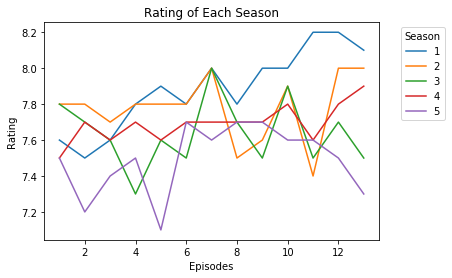

In [4]:
show_rating(connection, "Kim's Convenience")

## Test Case 1: Kim's Convenience

<u>Show overview</u>

Kim's convenience was first premiered in 2016 with Season 1. It has 5 seasons and each season was released every one or two years. 
Each season's average rating is between 7 and 8, and season 1 has a highest average rating of 7.88 and has two highest rated episodes of 8.2. Season 5 has the lowest average rating of 7.49 and has the lowest rated episode of 7.1.

**Season Trend:** The average rating is a downward trend, but there is minimal difference and keeps a fairly high rating for each shows. The fairly high ratings of each seasons imply that the show was continued constantly due to its popularity.

**Episode Trend:** For seasons 1 and 3, the last half episodes had a higher rating than the early episodes. Season 4 shows a steady rating of each episodes. Episode 5 has a spike for most seasons and the last episode's rating has the most variance. 

**Upcoming Season:** It is fairly acceptable to expect another season in the future. Even though season 5 has the lowest rated episode and average rating, the rating hasn't drastically decrease and is barely apart from other seasons.

Show: Emily in Paris

Number of seasons: 4

Season 1 was premiered in 2020
The average rating is 7.34

Season 2 was premiered in 2021
The average rating is 7.07

Season 3 doesn't have recorded ratings!

Season 4 doesn't have recorded ratings!


Lowest rated episode:
Rating :6.7
Season 2, episode 4: Jules and Em

Highest rated episode:
Rating :7.7
Season 1, episode 10: Cancel Couture



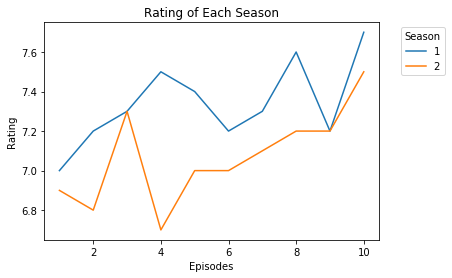

In [5]:
show_rating(connection, "Emily in Paris")

## Test Case 2: Emily in Paris

<u>Show overview</u>

Emily in Paris was first premiered in 2020 with Season 1. It has 4 seasons and each season was released every year. Season 3 and 4 wasn't rated yet. 
Each season's average rating is between 7 and 7.5, and season 1 has a highest average rating of 7.88 and has the highest rated episodes of 7.7. Season 2 has the lowest average rating of 7.07 and has the lowest rated episode of 6.7.

**Season Trend:** The average rating is a downward trend, but there is minimal difference and keeps a fairly high rating for each shows. The fairly high ratings of each seasons alludes that the show was continued constantly due to its popularity.

**Episode Trends:** Both season's rating is an upward trend and the last episode has the highest rating. This implies that the last episodes has a satisfactory ending and the audience is looking forward for upcoming season.

**Upcoming Season:** It is fairly positive to expect another season in the future. Even though season 2 has the lowest rated episode and average rating, the rating hasn't drastically decrease and is barely apart from other seasons. 

<u>Interesting Note</u>
Seasons 3 and 4 doesn't have any ratings. This alludes that season 3 was recently released and season 4 is already in progress for a new release.

Show: Stranger Things

Number of seasons: 5

Season 1 was premiered in 2008
The average rating is 7.31

Season 2 was premiered in 2017
The average rating is 8.47

Season 3 was premiered in 2019
The average rating is 8.51

Season 4 doesn't have recorded ratings!

Season 5 doesn't have recorded ratings!


Lowest rated episode:
Rating :2.9
Season 1, episode 4: Latchkeepers

Highest rated episode:
Rating :9.3
Season 1, episode 8: Chapter Eight: The Upside Down
Season 2, episode 9: Chapter Nine: The Gate



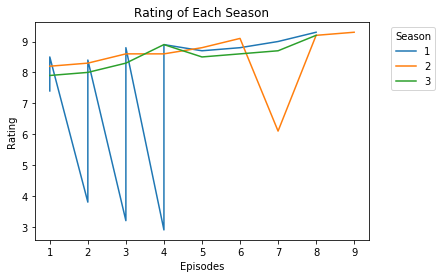

In [6]:
show_rating(connection, "Stranger Things")

## Test Case 3: Stranger Things

<u>Show overview</u>

Stranger Things was first premiered in 2008 with Season 1. It has 3 seasons and season 2 was released 9 years after.
Each season's average rating is between 7 and 8, and season 3 has a highest average rating of 7.88 and both seasons 1 and 2 has the highest rated episodes of 9.3. Season 1 has the lowest average rating of 7.31 and has the lowest rated episode of 2.9.

**Season Trend:** The average rating is an upward trend and there has been a drastic improvement from season 1. The successful rating of season 2 led to an immediate production of season 3 in two years.

**Episode Trend:** Season 1's first half episodes ratings were mostly low, but later ratings were high of 9. Season 2 and 3 has a constant high rating in between 8 and 9, with only ep 7 of season 2's rating of 6. All season's rating is an upward trend and the last episode has the highest rating. This implies that the last episodes has a satisfactory ending and the audience is looking forward for the upcoming season.

**Upcoming Season:** It is fairly positive to expect another season in the future. The recent seasons showed impressive progress, compared to season 1, and recent releases of seasons 4 and 5 doesn't have ratings yet.

<u>Interesting Note</u>

It is possible that the show wasn't subjected for continuation and was forgotten for a few years, after it's first release, because of the poor ratings and the premiered year gap between season 1 and 2. The director and casts might have changed for a better success and it lead to an impressive outcome.

## Function Definition: director_actor()

In the code cell below we define the`director_actor(dbcon, director_name)` function.  This function is designed to analyze and provide insights on the relationship between the director and the most appeared actor based on data strored in the `imdb.db` database. Here's a breakdown of what it does:

**SQL Query Construction:** The function constructs a SQL query using a text-based approach with *binding*. These queries are used to extract specific information from the database related to the show's overall rating of each seasons and every ratings of episodes.
 
**Executing SQL Queries:** After constructing the SQL queries, the function *binds* the necessary parameters (like the director_name) and executes the queries using Pandas' `read_sql_query()` function to read the SQL results into a DataFrame.

**Textual Output:** The function then prints out textual information about a summary of the director and actor, including the number of actors the director worked with and the most appeared actor. It also highlights the movies the actor was casted and their ratings.

**Data Visualization:** The function generates a histogram showing the frequency of actors. In addition, a line graph is plotted to show the movie ratings the actor was casted. They utilize the query to create and display both visualizations.

In [7]:
def director_actor(dbcon, director_name):
    # Define the SQL query needed for the text output and line graph using the binding method
    pyquery1 = """
    SELECT p.name, t.premiered-p.born AS age, t.primary_title, r.rating, t.premiered
    FROM crew AS c
    INNER JOIN people AS p USING(person_id)
    INNER JOIN titles AS t USING(title_id)
    INNER JOIN (SELECT DISTINCT title_id
    FROM titles AS t INNER JOIN crew AS c USING(title_id)
    INNER JOIN people AS p USING(person_id) WHERE p.name = :name_in) AS n USING(title_id)
    LEFT JOIN ratings as r USING(title_id)
    WHERE c.category = 'actor' AND t.type = 'movie'
    ORDER BY p.name, age;
    """

    # Bind the query
    prepare_stmt = sa.sql.text(pyquery1)
    bound_stmt = prepare_stmt.bindparams(name_in = director_name)
    
    # Pass the query to the DBMS and obtain the resulting table as a dataframe
    df1 = pd.read_sql_query(bound_stmt, dbcon)

    # Print the director's name
    print("========================================================")
    print("Director: "+str(director_name))
    print("========================================================")
    print()
    
    # Print the number of actors the director worked with
    actor_count = df1.name.nunique()
    print(str(director_name)+" worked with "+str(actor_count)+" actors.")
    print()
    
    # Create and display the plot
    plt.hist(df1.name.value_counts())
    plt.xlabel('Frequency')
    plt.ylabel('Number of Actors')
    plt.title('Histogram of Casted Actors')
    plt.show()
    print()
    
    print("========================================================")
    print()
    
    # Get the most casted actor
    value_counts = df1['name'].value_counts()
    max_count = value_counts.max()
    max_actors = []

    # Append the actor to a list
    for value, count in value_counts.items():
        if count == max_count:
            max_actors.append(value)

    # Print the analysis of listed actors 
    print("Analysis of the most appeared actor")
    print()
    
    # Print the actor's name using a for loop
    for actor in max_actors:
        print(str(actor)+" appeared "+str(max_count)+" times and was casted in:")
        print()
        
        # Get the movies the actor was casted in
        max_movies = df1[df1['name']==actor]
        
        # Print the movie's title, the actor's age when it was premiered, and movie's rating using a for loop
        for index, movie in max_movies.iterrows():
            print(str(movie.primary_title)+" in "+str(movie.premiered))
            print("At age "+str(int(movie.age)))
            print("Rating = "+str(movie.rating))
            print()
        # Create a plot
        plt.plot(max_movies.primary_title, max_movies.rating, label=actor)
        print()

    # Display the line graph
    plt.title("Ratings for Each Movie")
    plt.xlabel('Movies')
    plt.ylabel('Rating')
    plt.legend(loc='lower right')
    plt.show()

Director: Christopher Nolan

Christopher Nolan worked with 35 actors.



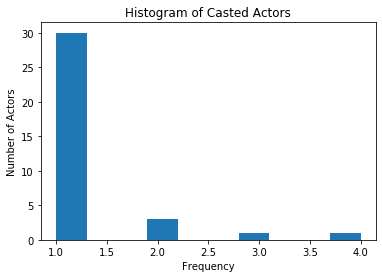



Analysis of the most appeared actor

Christian Bale appeared 4 times and was casted in:

Batman Begins in 2005
At age 31
Rating = 8.3

The Prestige in 2006
At age 32
Rating = 8.5

The Dark Knight in 2008
At age 34
Rating = 9.1

The Dark Knight Rises in 2012
At age 38
Rating = 8.4




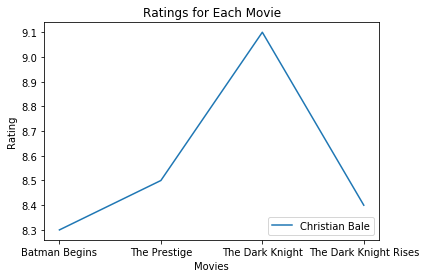

In [8]:
director_actor(connection, "Christopher Nolan")

## Test Case 1: Christopher Nolan

<u>Insight</u>

Christopher Nolan worked with 35 actors and three actors worked with Nolan twice. Christian Bale was casted four times. 

**Most Appeared Actor:** Christian Bale

Christian Bale worked with Christopher Nolan from 2005~2012. His first appearance on Nolan's work had a high rating of 8.3 The movie ratings had an upward trend, except for the last movie, The Dark Knight Rises, with a rating of 8.4. The similar titles of "The Dark Knight" and "The Dark Knight Rises" imply that they are series. It is possible that Christian Bale planned to retire, after the last "The Dark Knight" series, because he nearly reached his 40s and doesn't have any movie records with Christopher Nolan after 2012.

Director: Steven Spielberg

Steven Spielberg worked with 107 actors.



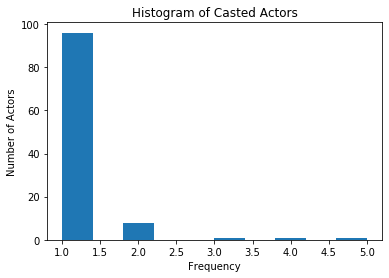



Analysis of the most appeared actor

Tom Hanks appeared 5 times and was casted in:

Saving Private Ryan in 1998.0
At age 42
Rating = 8.6

Catch Me If You Can in 2002.0
At age 46
Rating = 8.1

The Terminal in 2004.0
At age 48
Rating = 7.4

Bridge of Spies in 2015.0
At age 59
Rating = 7.6

The Post in 2017.0
At age 61
Rating = 7.2




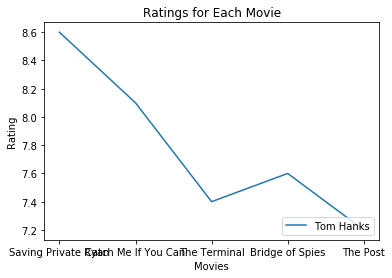

In [9]:
director_actor(connection, "Steven Spielberg")

## Test Case 2: Steven Spielberg

<u>Insight</u>

Steven Spielberg worked with 107 actors and approximately ten actors that worked with Speilberg twice. Tom Hanks appeared five times. 

**Most Appeared Actor:** Tom Hanks

Tom Hanks worked with Steven Spielberg from 1998~2017. His first appearance on Spielberg's work had a high rating of 8.6. Overall, the movie ratings had a downward trend from 8.6 to 7.2. It is possible that Spielberg stopped casting Hanks, due to the declining rating outcome. 